## Imports i definició de les variables d'arxius
---

In [1]:

import re #Regexs
import os #Acces a fitxers

import nltk #Tokenització
nltk.download('punkt') #Tokenització

import numpy as np #Matriu de confusió
import seaborn as sns #Matriu de confusió
import matplotlib.pyplot as plt #Matriu de confusió
import pandas as pd #Matriu de confusió
import sklearn #Matriu de confusió

train_files_list = [f for f in os.listdir('corpora') if re.search(r'_trn\.txt$', f)]
test_files_list = [f for f in os.listdir('corpora') if re.search(r'_tst\.txt$', f)]

print(train_files_list)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['deu_trn.txt', 'eng_trn.txt', 'fra_trn.txt', 'ita_trn.txt', 'nld_trn.txt', 'spa_trn.txt']


## Preprocessing
---

· Eliminar digits del text 
· Convertir tot el text a minuscula
· Eliminar caracters especials
· Substitueix els espais en blanc continus per un de sol
· Concatena totes les frases amb un espai doble al mig


In [2]:

def preprocessing(text):
    
    text = re.sub(r'[^\w\s]', '', text) # Elimina signes de puntuació
    text = re.sub(r'\d+', '', text) # Elimina números
    text = text.lower() # Converteix a minúscules
    text = re.sub(r'[\s\n]+', ' ', text) # Elimina espais en blanc sobrants excepte \n
    text = re.sub(r' +', ' ', text) # Elimina espais en blanc llargs
    text = re.sub(r'\n', '  ', text) # Substitueix \n per dos espais en blanc
    
    
    
    return text


# Creació dels trigrames de caracters, amb la seva freqüència
---

In [3]:

def character_trigrams_finder(text, flag='trn'):
    finder = nltk.TrigramCollocationFinder.from_words(text)
    if flag == 'trn':
        finder.apply_freq_filter(5)
    trigrams = finder.ngram_fd.items()
    trigrams = sorted(trigrams, key=lambda x: x[1], reverse=True)

    return trigrams

In [4]:
def word_trigrams_finder(text, flag='trn'):
    finder = nltk.TrigramCollocationFinder.from_words(nltk.word_tokenize(text))
    if flag == 'trn':
        finder.apply_freq_filter(5)
    trigrams = finder.ngram_fd.items()
    trigrams = sorted(trigrams, key=lambda x: x[1], reverse=True)

    return trigrams

In [5]:
def trigram_assigner_ch(train_files_list):
    
    enclosed_trigrams_ch = {}

    for file in train_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID de l'idioma
            print(language_id)
            text = f.read()
            text = preprocessing(text)
            enclosed_trigrams_ch[language_id] = character_trigrams_finder(text)

    return enclosed_trigrams_ch


In [6]:
def trigram_assigner_wds(train_files_list):
    
    enclosed_trigrams_wds = {}

    for file in train_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID de l'idioma
            print(language_id)
            text = f.read()
            text = preprocessing(text)
            enclosed_trigrams_wds[language_id] = word_trigrams_finder(text)
            
    return enclosed_trigrams_wds

In [7]:
trigrams_ch = trigram_assigner_ch(train_files_list)

deu
eng
fra
ita
nld
spa


In [8]:
trigrams_ch

{'deu': [(('e', 'n', ' '), 72300),
  (('e', 'r', ' '), 45659),
  ((' ', 'd', 'e'), 30147),
  (('d', 'e', 'r'), 23029),
  (('i', 'e', ' '), 22724),
  (('i', 'c', 'h'), 21335),
  (('e', 'i', 'n'), 21119),
  (('s', 'c', 'h'), 20400),
  ((' ', 'd', 'i'), 19938),
  (('d', 'i', 'e'), 19806),
  (('c', 'h', ' '), 19532),
  (('n', ' ', 'd'), 18274),
  (('i', 'n', ' '), 16110),
  (('n', 'd', ' '), 16089),
  ((' ', 'e', 'i'), 15015),
  (('c', 'h', 'e'), 14996),
  ((' ', 'u', 'n'), 14595),
  (('d', 'e', 'n'), 14231),
  (('t', 'e', 'n'), 13743),
  ((' ', 'a', 'u'), 13621),
  ((' ', 'd', 'a'), 13574),
  (('u', 'n', 'd'), 13388),
  ((' ', 'b', 'e'), 12259),
  (('t', 'e', ' '), 12217),
  (('i', 'n', 'e'), 12091),
  (('g', 'e', 'n'), 12056),
  ((' ', 'i', 'n'), 12050),
  (('c', 'h', 't'), 12043),
  ((' ', 'g', 'e'), 11990),
  (('t', 'e', 'r'), 10872),
  (('n', ' ', 's'), 10853),
  (('u', 'n', 'g'), 10807),
  (('e', 's', ' '), 10782),
  (('n', 'd', 'e'), 10281),
  ((' ', 's', 'i'), 9976),
  (('t', ' ', 

## Separar el test per oracions
---

In [9]:

def test_files_separator(test_files_list):
    test_files = {}
    for file in test_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID de l'idioma
            print(language_id)
            text = f.read()
            test_files[language_id] = nltk.sent_tokenize(text)
            for i in range(len(test_files[language_id])):
                test_files[language_id][i] = preprocessing(test_files[language_id][i])
    return test_files

In [10]:
test_files = test_files_separator(test_files_list)


deu
eng
fra
ita
nld
spa


In [ ]:
for elem in range(len(test_files['deu'])):
    print(test_files['deu'][elem])

In [17]:
for idioma in trigrams_ch:
    print(idioma)
    test_files[idioma] =  [elemento for elemento in test_files[idioma] if len(elemento) >= 3]

deu
eng
fra
ita
nld
spa


## Funcio de suavitzat
---


Sumatori del logaritme de (les aparicions del trigrama en el train + alpha / trigrames que apareixen en el train + alpha * vocabulari(beta))

In [47]:
def suavitzat(oracio, prints = False, alpha = 0.5):
    #chars es una lista, trigrams_ch es un dict
    chars = character_trigrams_finder(oracio, 'test')
    probabilities = {}
    for idioma in trigrams_ch: #iterem per idioma
        prob = 0
        for i in range(len(chars)):
            beta = (len(trigrams_ch[idioma]))
            aparicions = 0
            for elem in trigrams_ch[idioma]: #busco si el trigrama existe en el idioma
                if chars[i][0] == elem[0]:
                    aparicions = elem[1]
                    break
            prob_trigrama = ((aparicions + alpha) / ((len(trigrams_ch[idioma])) + alpha * beta)) # la nostra beta (trigrames totals del idioma) es el nombre de trigrames totals del train
            prob += np.log(prob_trigrama)
        probabilities[idioma] = prob
    sorted_prob = sorted(probabilities.items(), key=lambda x:x[1], reverse=True)
    sort_prob = dict(sorted_prob)
    if prints == True:
        print(oracio, '\n')
        print (' L\'idioma de la oració és:', list(sort_prob.keys())[0])
        print ('\n', sort_prob)
    return list(sort_prob.keys())[0]
#esta pal Enzo

In [48]:
suavitzat(test_files['eng'][1478])



'eng'

In [50]:

prediccio = []
valor_obj = []

for idioma in test_files:
    for oracio in test_files[idioma]:
        valor_obj.append(idioma)
        prediccio.append(suavitzat(oracio)) 

KeyboardInterrupt: 

In [41]:
matriu_confusio = sklearn.metrics.confusion_matrix(valor_obj, prediccio)

print("Matriu de Confusió:")
print(matriu_confusio)

Matriu de Confusió:
[[10352    71    13    28    16    11]
 [    3 10046     0    14     1     2]
 [    1    24 10054    23     3     7]
 [    0     9     2 10167     3     3]
 [   17   102     8    21 10152    12]
 [    1     9     4    25     5  9898]]


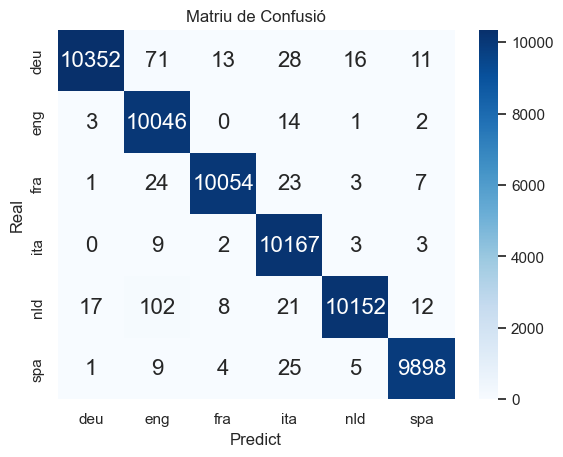

In [43]:
labels = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']
#matriu_confusio_ = sklearn.preprocessing.normalize(matriu_confusio, axis=1,)
#matriu_confusio_ = np.round(matriu_confusio, decimals=2)

sns.heatmap(matriu_confusio, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriu de Confusió')
plt.show()

In [32]:
type(train_files_list)

list